## 0. Load Packages

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage import io,color
from os import walk
import os
import random
from datetime import datetime
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import cv2

## 1. Some Paths

In [49]:
path="images/60-80"
test_path=path+"/test/"
predict_path=path+"/predict/"
model_path = path+"/saved model/"

## 2. Some Functions

### a. Functions for images

In [27]:
#Convert RGB images to LAB using CIELAB, then return input X (L), target Y (A. B)
def rgbtolab_batch(path):
    X=[]
    Y=[]
    j=1
    row=[]
    column=[]

    for (dirpath,dirnames,filenames) in walk(path):
        for filename in filenames:
            if filename.endswith(".jpg")==True:
                # Get images
                image = img_to_array(load_img(dirpath+filename))
                image = np.array(image, dtype=float)
                column.append(len(image[0]))
                row.append(len(image))
                image = cv2.resize(image, (80,60))
                x = rgb2lab(1.0/255*image)[:,:,0]
                y = rgb2lab(1.0/255*image)[:,:,1:]
                y /= 128

                X.append(x)
                Y.append(y)
                j +=1
                n_test=len(X)

    return X,Y,row,column

#Convert LAB channels to RGB for a list of image
def labtorgb_batch(l,a,b,row,column):
    rgb=[]
    for i in range(len(l)):
        lab=np.dstack([l[i],a[i],b[i]])
        img=color.lab2rgb(lab)
        img = cv2.resize(img, (column[i],row[i]))
        rgb.append(img)
    return rgb

def showgray(path):
    for (dirpath,dirnames,filenames) in walk(path):
        for filename in filenames:
            rgb=io.imread(dirpath+filename,plugin='matplotlib')
            lab=color.rgb2lab(rgb)
            lab_copy=lab.copy()
            lab_copy[:,:,1]=0
            lab_copy[:,:,2]=0
            grey=color.lab2rgb(lab_copy)
            #plt.imsave(img[:-4]+'_gray.jpg',grey)
            plt.imshow(grey)
            plt.show()

def showRGB(img_list):
    for i in img_list:
        plt.imshow(i)
        plt.show()
        
#Save colorized image
def savePredict(img_list):
    for i in range(len(img_list)):
        plt.imsave("{}{}_predict{}.jpg".format(predict_path,i,datetime.today().strftime("%m%d%Y-%H%M%S")),img_list[i])

### b. Functions for Loading Model and weights

In [51]:
#Load Model and weights
def load_model(model_name):

    json_file = open('{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    #load weights into new model
    loaded_model.load_weights("{}.h5".format(model_name))
    print("Loaded model from disk")
    return loaded_model

#Load Image
def load_image(image_path):
    X,Y,row,column = rgbtolab_batch(image_path)
    n_test=len(X)
    # Pre-process the data by reshaping
    X=np.array(X)
    Y=np.array(Y)
    X = X.reshape(n_test, 60, 80, 1)
    Y = Y.reshape(n_test, 60, 80, 2)
    return X,Y,row,column

#Load Model and Image - Colorization
def load_all(model_name,image_path):
    loaded_model=load_model(model_name)
    X,Y,row,column=load_image(image_path)
    n_test=len(X)
    loaded_model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
    loaded_model.evaluate(X,Y,batch_size=10)
    Y_predict=loaded_model.predict(X)
    Y_predict *=128
    Y_a=Y_predict[:,:,:,0].reshape(n_test,60,80,1)
    Y_b=Y_predict[:,:,:,1].reshape(n_test,60,80,1)
    Y_ori_a=Y[:,:,:,0].reshape(n_test,60,80,1)*128
    Y_ori_b=Y[:,:,:,1].reshape(n_test,60,80,1)*128
    rgb_list=labtorgb_batch(X,Y_a,Y_b,row,column)
    rgb_original=labtorgb_batch(X,Y_ori_a,Y_ori_b,row,column)
    return rgb_list,rgb_original

## 3. Colourization

In [52]:
# Load model and image path, get colorized images and original images
colorized, original = load_all(model_path+"model_0215",test_path)

Loaded model from disk
12/12 [==============================] - 4s 303ms/step


Colorized Images:


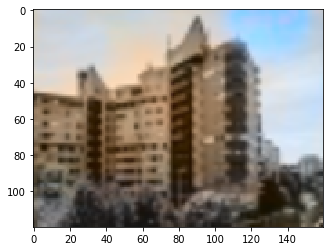

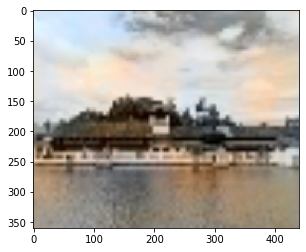

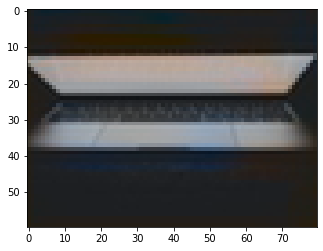

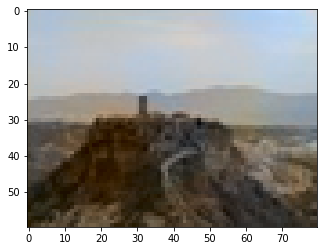

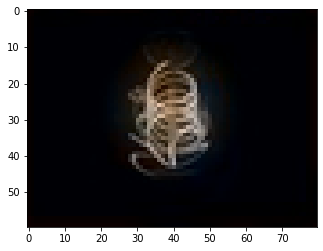

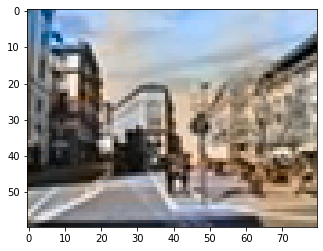

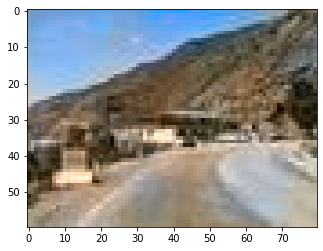

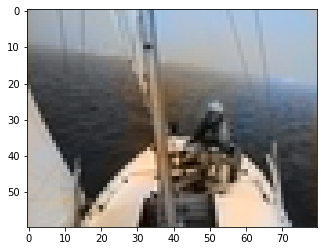

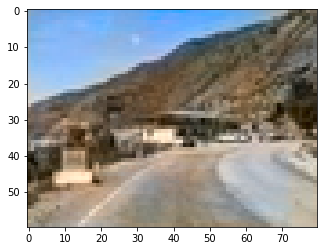

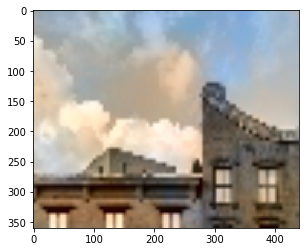

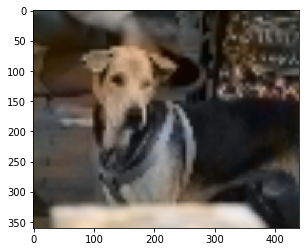

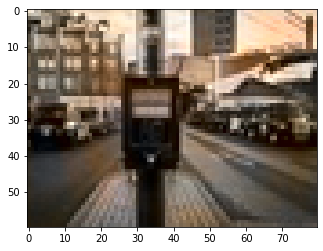

In [53]:
# print colorized images
print("Colorized Images:")
showRGB(colorized)

Original Images


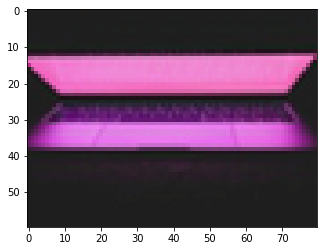

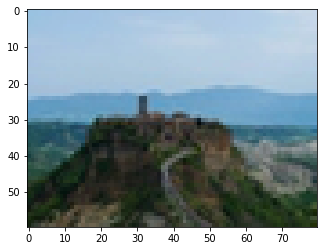

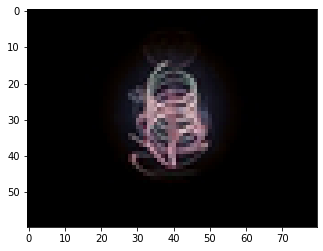

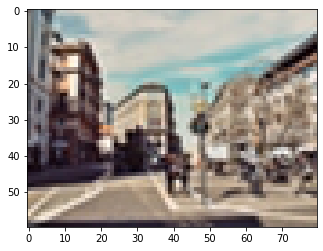

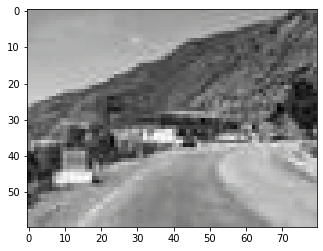

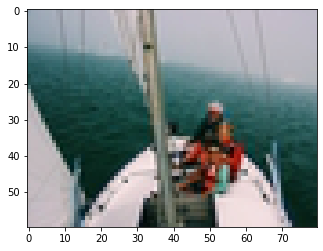

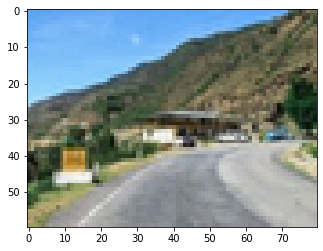

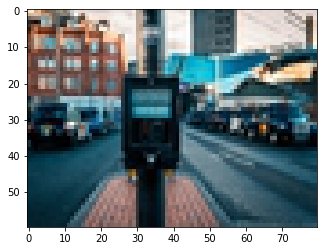

In [28]:
# print original images
print("Original Images")
showRGB(original)

In [ ]:
# save colorized images
savePredict(colorized)
print("Predicted images saved to {}".format(predict_path))